# Lesson 2: Construct a Multi-Agent Workflow

In this lesson, you'll build a data agent that can perform web research, answer questions, and generate charts.

```
Data Agent Architecture
                    
                    
        +-------+           +------------------+
        | Start |---------->|     Planner      |
        +-------+           |   [👥] [⚙️]      |
                           +------------------+
                                    |
                                    | ↕
                                    v
                           +------------------+
                           |    Executor      |
                           |   [👥] [⚙️]      |
                           +------------------+
                                    |
                    +---------------+---------------+
                    |               |               |
                    v               v               v
          +----------------+  +-----------+  +----------------+
          |      Web       |  |   Chart   |  |                |
          |  Researcher    |  | Generator |  |  Synthesizer   |
          |    (Tavily)    |  | (Python)  |  |                |
          | Assistant Agent|  +-----------+  | Assistant Agent|
          +----------------+        |        +----------------+
                                    v               |
                              +-----------+         |
                              |   Chart   |         |
                              |Summarizer |         |
                              |           |         |
                              |Assistant  |         |
                              |  Agent    |         |
                              +-----------+         |
                                    |               |
                                    +-------+-------+
                                            |
                                            v
                                       +-------+
                                       |  End  |
                                       +-------+
```

Let's load the environment variables that define the OpenAI API and Tavily API keys.

In [1]:
from dotenv import load_dotenv
_ = load_dotenv(override=True)

**Note**: These variables are already defined in this environment. If you'd like to run the notebook locally, you can define them in a `.env` file. For an env template, you can check the file `env.template` in this lesson's folder.

<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>To access <code>requirements.txt</code>, <code>env.template</code>, <code>prompts.py</code>, and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

</div>

## 2.1 Initialize the agent's state

State provides the agent with a shared, evolving memory across nodes so that the agents have the context and instructions needed to act coherently and achieve the goal.

In [2]:
from typing import Literal, Optional, List, Dict, Any, Type
from langgraph.graph import MessagesState

# Custom State class with specific keys
class State(MessagesState):
    user_query: Optional[str] # The user's original query
    enabled_agents: Optional[List[str]] # Makes our multi-agent system modular on which agents to include
    plan: Optional[List[Dict[int, Dict[str, Any]]]] # Listing the steps in the plan needed to achieve the goal.
    current_step: int # Marking the current step in the plan.
    agent_query: Optional[str] # Inbox note: `agent_query` tells the next agent exactly what to do at the current step.
    last_reason: Optional[str] # Explains the executor’s decision to help maintain continuity and provide traceability.
    replan_flag: Optional[bool] # Set by the executor to indicate that the planner should revise the plan.
    replan_attempts: Optional[Dict[int, Dict[int, int]]] # Replan attempts tracked per step number.

**Note**: `State` inherits from `MessagesState`, which is defined with a single `messages` key that keeps track of the list of messages shared among agents. So in addition to the fields you just defined for `State`, it also has a `messages` field from `MessagesState`. 

## 2.2 Create planner

The planner takes in the user's query and generates a plan. The plan consists of a sequence of numbered steps; each step includes the action and the sub-agent that is assigned to that action.

In [3]:
from prompts import plan_prompt
from langgraph.types import Command
from langchain.schema import HumanMessage
from langchain_openai import ChatOpenAI

import json

In [4]:
reasoning_llm = ChatOpenAI(
    model="o3",
    model_kwargs={"response_format": {"type": "json_object"}},
)

In [5]:
def planner_node(state: State) -> Command[Literal['executor']]:
    """
    Runs the planning LLM and stores the resulting plan in state.
    """
    # 1. Invoke LLM with the planner prompt
    llm_reply = reasoning_llm.invoke([plan_prompt(state)])

    # 2. Validate JSON
    try:
        content_str = llm_reply.content if isinstance(
            llm_reply.content, str) else str(llm_reply.content)
        parsed_plan = json.loads(content_str)
    except json.JSONDecodeError:
        raise ValueError(
            f"Planner returned invalid JSON:\n{llm_reply.content}")

    # 3. Store as current plan only
    replan = state.get("replan_flag", False)
    updated_plan: Dict[str, Any] = parsed_plan

    return Command(
        update={
            "plan": updated_plan,
            "messages": [HumanMessage(
                content=llm_reply.content,
                name="replan" if replan else "initial_plan")],
            "user_query": state.get("user_query", state["messages"][0].content),"current_step": 1 if not replan else state["current_step"],
            # Preserve replan flag so executor runs planned agent
            # once before reconsidering
            "replan_flag": state.get("replan_flag", False),
            "last_reason": "",
            "enabled_agents": state.get("enabled_agents"),
        },
        goto="executor",
    )

## 2.3 Create executor

The executor executes the plan by identifying the sub-agent that should go next and generating the instructions (or agent query) for the chosen agent. Based on the results of the retrieval step (web search results in this case), the executor might decide that the plan needs to be changed. In this case, it goes back to the planner and asks it to generate an updated plan.

In [7]:
from prompts import executor_prompt
from langgraph.graph import END

MAX_REPLANS = 3

In [8]:
def executor_node(
    state: State,
) -> Command[Literal["web_researcher", "chart_generator", "synthesizer", "planner"]]:

    plan: Dict[str, Any] = state.get("plan", {})
    step: int = state.get("current_step", 1)

    # 0) If we *just* replanned, 
    # run the planned agent once before reconsidering.
    if state.get("replan_flag"):
        planned_agent = plan.get(str(step), {}).get("agent")
        return Command(
            update={
                "replan_flag": False,
                "current_step": step + 1,  # advance because we executed the planned agent
            },
            goto=planned_agent,
        )

    # 1) Build prompt & call LLM
    llm_reply = reasoning_llm.invoke([executor_prompt(state)])
    try:
        content_str = llm_reply.content if isinstance(llm_reply.content, str) else str(llm_reply.content)
        parsed = json.loads(content_str)
        replan: bool = parsed["replan"]
        goto: str   = parsed["goto"]
        reason: str = parsed["reason"]
        query: str  = parsed["query"]
    except Exception as exc:
        raise ValueError(f"Invalid executor JSON:\n{llm_reply.content}") from exc

    # Upodate the state
    updates: Dict[str, Any] = {
        "messages": [HumanMessage(content=llm_reply.content, name="executor")],
        "last_reason": reason,
        "agent_query": query,
    }

    # Replan accounting
    replans: Dict[int, int] = state.get("replan_attempts", {}) or {}
    step_replans = replans.get(step, 0)

    # 2) Replan decision
    if replan:
        if step_replans < MAX_REPLANS:
            replans[step] = step_replans + 1
            updates.update({
                "replan_attempts": replans,
                "replan_flag": True,     # ensure next turn executes the planned agent once
                "current_step": step,    # stay on same step for the new plan
            })
            return Command(update=updates, goto="planner")
        else:
            # Cap hit: skip this step; let next step (or synthesizer) handle termination
            next_agent = plan.get(str(step + 1), {}).get("agent", "synthesizer")
            updates["current_step"] = step + 1
            return Command(update=updates, goto=next_agent)

    # 3) Happy path: run chosen agent; advance only if following the plan
    planned_agent = plan.get(str(step), {}).get("agent")
    updates["current_step"] = step + 1 if goto == planned_agent else step
    updates["replan_flag"] = False
    return Command(update=updates, goto=goto)

## 2.4 Create Web research agent

The web research sub-agent is a [ReAct agent](https://arxiv.org/abs/2210.03629) that uses [Tavily Search tool](https://python.langchain.com/docs/integrations/tools/tavily_search/) to search the web and answer the sub-query assigned to it. 

In [9]:
from langgraph.prebuilt import create_react_agent
from typing import Literal
from langchain_tavily import TavilySearch
from langchain_openai import ChatOpenAI

tavily_tool = TavilySearch(max_results=5)

tavily_tool.invoke("What is JP Morgan's stock price?")['results']

[{'url': 'https://tradingeconomics.com/jpm:us',
  'title': 'JPMorgan | JPM - Stock Price | Live Quote | Historical Chart',
  'content': 'JPMorgan | JPM - Stock Price | Live Quote | Historical Chart  | Capital One Financial | 215.99 |  | 1.79 | 0.83% | 37.82% | Oct/15 | Rowe Price | 106.13 |  | 0.77 | 0.73% | -2.94% | Oct/14 | | US Bank Index | 77 |  | 0.92 | 1.20% | 22.78% | Oct/15 | Looking ahead, we forecast J.P. Morgan Chase to be priced at 291.56 by the end of this quarter and at 265.28 in one year, according to Trading Economics global macro models projections and analysts expectations. **JPMorgan Stock Price Hits 4-week Low** **JPMorgan Stock Price Hits All-time High** **JPMorgan Stock Price Hits All-time High** Brent Crude Oil Edges Up, Still Near 5-Month Low',
  'score': 0.84918517,
  'raw_content': None},
 {'url': 'https://www.macrotrends.net/stocks/charts/JPM/jpmorgan-chase/stock-price-history',
  'title': 'JPMorgan Chase - 45 Year Stock Price History | JPM - Macrotrends',
  

In [10]:
from helper import agent_system_prompt

llm = ChatOpenAI(model="gpt-4o")

# Research agent and node
web_search_agent = create_react_agent(
    llm,
    tools=[tavily_tool],
    prompt=agent_system_prompt(f"""
        You are the Researcher. You can ONLY perform research 
        by using the provided search tool (tavily_tool). 
        When you have found the necessary information, end your output.  
        Do NOT attempt to take further actions.
    """),
)

In [11]:
agent_response = web_search_agent.invoke(
    {"messages":"what is jp morgan's current market cap?"})

In [12]:
agent_response['messages'][-1].content

'The current market capitalization of JP Morgan is approximately $818.22 billion. You can find more details on the [Wall Street Journal](https://www.wsj.com/market-data/quotes/JPM) or [Bloomberg](https://www.bloomberg.com/quote/JPM:US) websites.'

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
    <p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Also, the answer depends on the web search results since the question asks for current market cap.

In [13]:
def web_research_node(
    state: State,
) -> Command[Literal["executor"]]:
    agent_query = state.get("agent_query")
    result = web_search_agent.invoke({"messages":agent_query})
    goto = "executor"
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="web_researcher"
    )
    return Command(
        update={
            # share internal message history of research agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

## 2.5 Create charting agent

If the user asks for the results to be charted, then the charting sub-agent can help with that. It first generates the Python code that generates the chart, and then executes the code using the `python_repl_tool`.

In [14]:
from helper import python_repl_tool

# Chart generator agent and node
# NOTE: THIS PERFORMS ARBITRARY CODE EXECUTION, 
# WHICH CAN BE UNSAFE WHEN NOT SANDBOXED
chart_agent = create_react_agent(
    llm,
    [python_repl_tool],
    prompt=agent_system_prompt(
        """
        You can only generate charts. You are working with a researcher 
        colleague.
        1) Print the chart first.
        2) Save the chart to a file in the current working directory.
        3) At the very end of your message, output EXACTLY two lines 
        so the summarizer can find them:
           CHART_PATH: <relative_path_to_chart_file>
           CHART_NOTES: <one concise sentence summarizing the main insight in the chart>
        Do not include any other trailing text after these two lines.
        """
    ),
)

In [15]:
def chart_node(state: State) -> Command[Literal["chart_summarizer"]]:
    result = chart_agent.invoke(state)
    # wrap in a human message, as not all providers allow
    # AI message at the last position of the input messages list
    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="chart_generator"
    )
    goto="chart_summarizer"
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
        },
        goto=goto,
    )

## 2.6 Create chart summary agent

This sub-agent generates a caption describing the chart generated by the chart generator.

In [16]:
chart_summary_agent = create_react_agent(
    llm,
    tools=[],  # Add image processing tools if available/needed.
    prompt=agent_system_prompt(
        "You can only generate image captions. You are working with a researcher colleague and a chart generator colleague. "
        + "Your task is to generate a standalone, concise summary for the provided chart image saved at a local PATH, where the PATH should be and only be provided by your chart generator colleague. The summary should be no more than 3 sentences and should not mention the chart itself."
    ),
)

In [17]:
def chart_summary_node(
    state: State,
) -> Command[Literal[END]]:
    result = chart_summary_agent.invoke(state)
    print(f"Chart summarizer answer: {result['messages'][-1].content}")
    # Send to the end node
    goto = END
    return Command(
        update={
            # share internal message history of chart agent with other agents
            "messages": result["messages"],
            "final_answer": result["messages"][-1].content,
        },
        goto=goto,
    )

## 2.7 Create a Synthesizer (Text Summarizer) Agent

In the case where the user does not ask for the results to be charted, the synthesizer sub-agent generates text that summarizes the retrieved results (in this case, the web search results).

In [18]:
llm = ChatOpenAI(model="gpt-4o")

In [19]:
def synthesizer_node(state: State) -> Command[Literal[END]]:
    """
    Creates a concise, human‑readable summary of the entire interaction,
    **purely in prose**.

    It ignores structured tables or chart IDs and instead rewrites the
    relevant agent messages (research results, chart commentary, etc.)
    into a short final answer.
    """
    # Gather informative messages for final synthesis
    relevant_msgs = [
        m.content for m in state.get("messages", [])
        if getattr(m, "name", None) in ("web_researcher", 
                                        "chart_generator", 
                                        "chart_summarizer")
    ]

    user_question = state.get("user_query", state.get("messages", [{}])[0].content if state.get("messages") else "")

    synthesis_instructions = (
        """
        You are the Synthesizer. Use the context below to directly 
        answer the user's question. Perform any lightweight calculations, 
        comparisons, or inferences required. Do not invent facts not 
        supported by the context. If data is missing, say what's missing
        and, if helpful, offer a clearly labeled best-effort estimate 
        with assumptions.\n\n
        Produce a concise response that fully answers the question, with 
        the following guidance:\n
        - Start with the direct answer (one short paragraph or a tight bullet list).\n
        - Include key figures from any 'Results:' tables (e.g., totals, top items).\n
        - If any message contains citations, include them as a brief 'Citations: [...]' line.\n
        - Keep the output crisp; avoid meta commentary or tool instructions.
        """
        )

    summary_prompt = [
        HumanMessage(content=(
            f"User question: {user_question}\n\n"
            f"{synthesis_instructions}\n\n"
            f"Context:\n\n" + "\n\n---\n\n".join(relevant_msgs)
        ))
    ]

    llm_reply = llm.invoke(summary_prompt)

    answer = llm_reply.content.strip()
    print(f"Synthesizer answer: {answer}")

    return Command(
        update={
            "final_answer": answer,
            "messages": [HumanMessage(content=answer, name="synthesizer")],
        },
        goto=END,           # hand off to the END node
    )

## 2.8 Build the agent graph

In [20]:
from langgraph.graph import START, StateGraph

workflow = StateGraph(State)
workflow.add_node("planner", planner_node)
workflow.add_node("executor", executor_node)
workflow.add_node("web_researcher", web_research_node)
workflow.add_node("chart_generator", chart_node)
workflow.add_node("chart_summarizer", chart_summary_node)
workflow.add_node("synthesizer", synthesizer_node)

workflow.add_edge(START, "planner")

graph = workflow.compile()

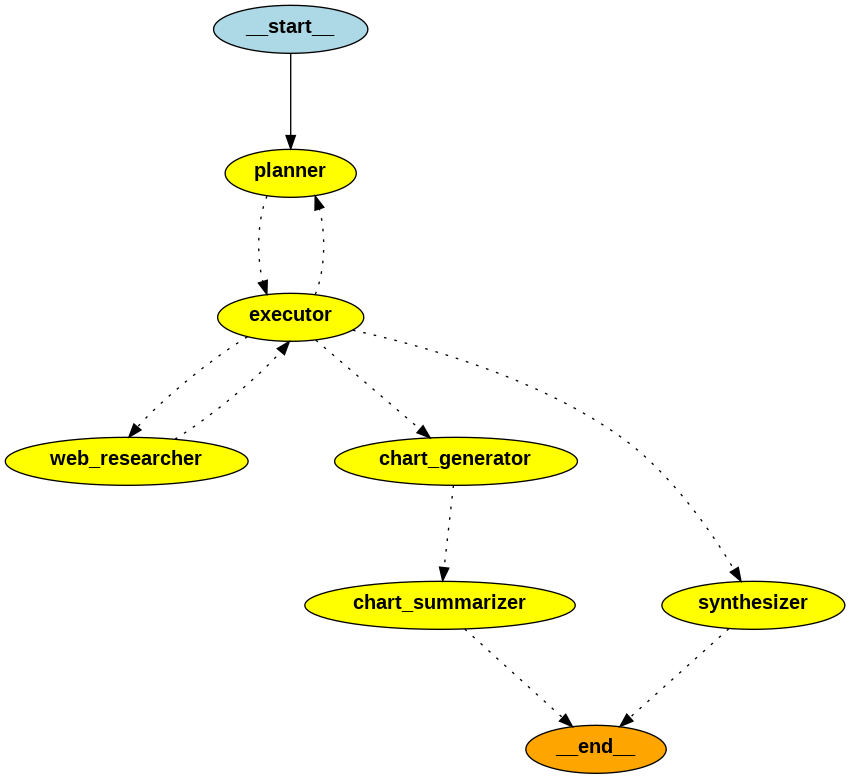

In [21]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_png()))

## 2.9 Use the agent

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ </b> The following two queries might take <b>2-5 minutes</b> to output the results.</p>

<div style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 
<p>🚨 &nbsp; <b>Different Run Results:</b> The output generated by AI chat models can vary with each execution due to their dynamic, probabilistic nature. Your results may differ from those shown in the video. For example: 

In the first query, the agent might decide to call the synthesizer instead of calling the chart generator. In this case, you will only see text summarizing the web search results instead of a chart, which means the agent's answer is not completely relevant to the user's query. This is what you'll learn how to evaluate in the next lessons.
</p>

Query: Chart the current market capitalization of the top 5 banks in the US?


Python REPL can execute arbitrary code. Use with caution.


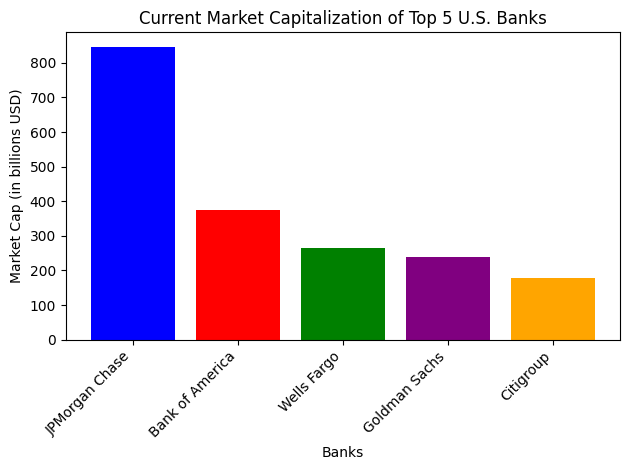

Chart summarizer answer: Based on the recent data, JPMorgan Chase has the highest market capitalization among the top U.S. banks at 845.69 billion USD, significantly outpacing the others, with Bank of America at 373.61 billion USD and Wells Fargo at 264.51 billion USD. Goldman Sachs and Citigroup trail behind with 239.95 billion and 179.19 billion USD respectively.
--------------------------------


In [24]:
from langchain.schema import HumanMessage
import json

query = "Chart the current market capitalization of the top 5 banks in the US?"
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["web_researcher", "chart_generator", 
                               "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

In [23]:
query = "Identify current regulatory changes for the financial services industry in the US."
print(f"Query: {query}")

state = {
            "messages": [HumanMessage(content=query)],
            "user_query": query,
            "enabled_agents": ["web_researcher", "chart_generator", 
                               "chart_summarizer", "synthesizer"],
        }
graph.invoke(state)

print("--------------------------------")

Query: Identify current regulatory changes for the financial services industry in the US.
Synthesizer answer: - **SEC**: New rules for private fund advisers to enhance transparency and risk management practices in the U.S. Treasury market have been adopted in 2023.
- **OCC**: Established the Office of Financial Technology in March 2023 to focus on fintech innovations.
- **CFPB**: Finalized a rule in March 2023 requiring data reporting on credit applications from small businesses, particularly those owned by women and minorities.
- **Federal Reserve**: Finalized principles for managing climate-related financial risks for large institutions as of October 2023.
- **FINRA**: Amendments to rule 4210 regarding margin requirements for agency transactions are set to be implemented by May 2024.

Citations: [1](https://www.sec.gov/newsroom/press-releases/2023-155), [2](https://www.sec.gov/newsroom/press-releases/2023-247), [3](https://www.occ.gov/news-issuances/news-releases/2023/nr-occ-2023-28.